In [1]:
import os
import sys
import pickle
import numpy as np
from math import exp
from scipy import stats
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from vizsequence.viz_sequence import plot_weights_given_ax
from scipy.special import softmax
import keras
import keras.losses
from keras.models import Model, Sequential, load_model
from keras import backend as K
import numpy.random as rng
import seaborn as sns
from collections import OrderedDict
from basepair.losses import twochannel_multinomial_nll
import modisco
import modisco.tfmodisco_workflow.workflow
from modisco.tfmodisco_workflow import workflow
import h5py
import modisco.util
from collections import Counter
from modisco.visualization import viz_sequence
import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

2020-11-28 11:30:08,527 [WARNING] From /users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

TF-MoDISco is using the TensorFlow backend.


In [2]:
all_post_counts_hypimps = np.load("/users/amr1/pho4/data/imp-scores/lncap_gr/post_counts_hypimps.npy")
all_post_counts_actualimps = np.load("/users/amr1/pho4/data/imp-scores/lncap_gr/post_counts_actualimps.npy")  
all_seqs = np.load("/users/amr1/pho4/data/imp-scores/lncap_gr/seqs.npy")

In [3]:
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["task0"],
                contrib_scores={"task0": all_post_counts_actualimps},
                hypothetical_contribs={"task0": all_post_counts_hypimps},
                one_hot=all_seqs)

grp = h5py.File("data/modisco/lncap_gr/task0_counts_results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Untrimmed - sequence (scaled by information content)


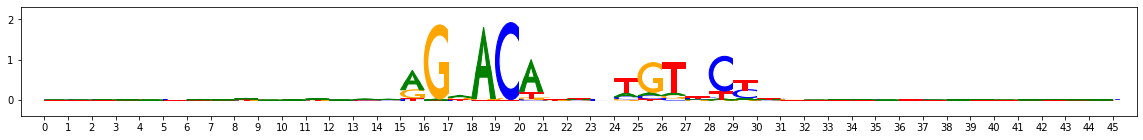

Untrimmed - task 0 hypothetical scores


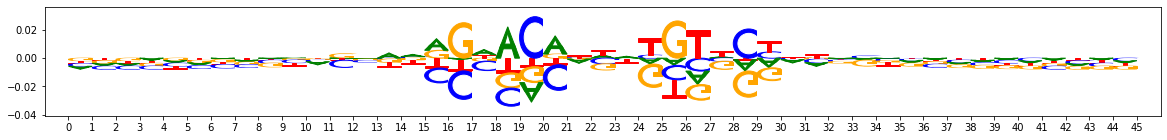

IC-trimmed - sequence (scaled by information content)


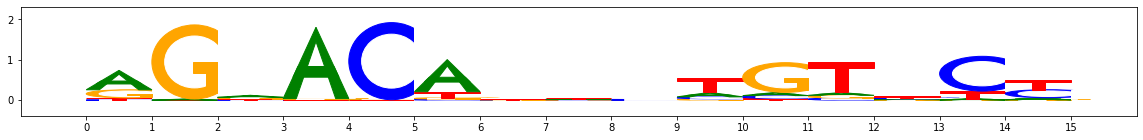

In [4]:
background = np.array([0.27, 0.23, 0.23, 0.27])
untrimmed_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_1"]
    .seqlets_to_patterns_result.patterns[0])
print("Untrimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(untrimmed_pattern["sequence"].fwd, background=background))
print("Untrimmed - task 0 hypothetical scores")
viz_sequence.plot_weights(untrimmed_pattern["task0_hypothetical_contribs"].fwd)
trimmed = untrimmed_pattern.trim_by_ic(ppm_track_name="sequence", background=background, threshold=0.3)
print("IC-trimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed["sequence"].fwd, background=background))

In [5]:
print(trimmed["task0_hypothetical_contribs"].fwd)

[[ 8.22767065e-03 -1.04855167e-02  5.55723675e-03 -7.00145385e-03]
 [-9.71742416e-04 -2.01203565e-02  2.50691674e-02 -8.04272296e-03]
 [ 3.74028949e-03 -6.70252002e-03 -2.07027919e-03  2.41676800e-03]
 [ 2.21216915e-02 -1.28213977e-02 -1.07305980e-02 -1.03975509e-02]
 [-1.38494681e-02  2.93319485e-02 -1.12324744e-02 -6.03170980e-03]
 [ 1.28415076e-02 -1.81020048e-02  2.92130852e-03 -4.64963007e-03]
 [-3.01798544e-03  9.33637785e-05 -6.02403577e-04  1.96678636e-03]
 [ 2.48742280e-03 -4.00898437e-03 -4.33975604e-03  3.51016206e-03]
 [ 1.36161983e-03 -5.24404273e-04 -3.16280685e-04 -2.42560081e-03]
 [-4.15494501e-03  2.13001907e-03 -1.65231681e-02  1.17894664e-02]
 [-5.07512788e-03 -1.02935418e-02  2.63245466e-02 -1.29536157e-02]
 [-9.51559095e-03 -9.12703833e-03 -1.10506976e-02  1.99119880e-02]
 [ 1.19035665e-03 -2.18306217e-03 -5.69982119e-03  3.77776586e-03]
 [-8.06771558e-03  2.06453712e-02 -1.85272846e-02 -1.00039051e-03]
 [-6.81168085e-03  4.44618637e-03 -9.08298603e-03  7.69658173e

In [6]:
imp_scores = all_post_counts_actualimps
onehot_seq = np.array(all_seqs)
fwd_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["task0_hypothetical_contribs"].fwd)
rev_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["task0_hypothetical_contribs"].rev)

#We take the max of the masked_cosine_sim on the fwd and reverse strands
is_fwd_masked_cosine_sim = fwd_masked_cosine_sim > rev_masked_cosine_sim
masked_cosine_sim = (fwd_masked_cosine_sim*is_fwd_masked_cosine_sim
                     + rev_masked_cosine_sim*(is_fwd_masked_cosine_sim==False))

#Also look at the total sum of scores in each window
sum_scores = modisco.util.compute_sum_scores(imp_scores=imp_scores,
                                             window_size=len(trimmed["task0_hypothetical_contribs"].fwd))

/users/amr1/tfmodisco/modisco/util.py:497: RuntimeWarning: invalid value encountered in true_divide
  norm_deeplift_scores*norm_masked_weightmat)
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


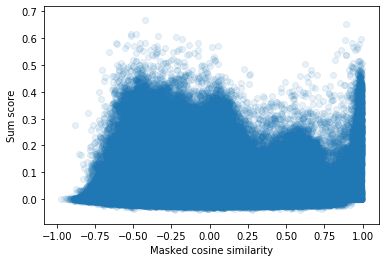

In [7]:
plt.scatter(masked_cosine_sim.ravel(), sum_scores.ravel(), alpha=0.1)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.show()

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


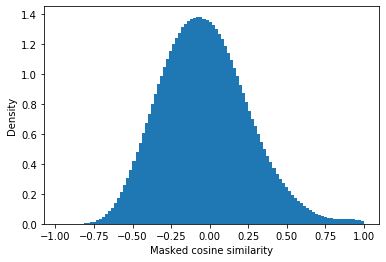

In [8]:
plt.hist(masked_cosine_sim.ravel(), bins=100, density=True)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Density")
plt.show()

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


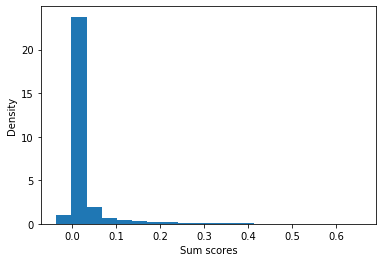

In [9]:
masked_cosine_sim_thresh = 0.7
plt.hist(sum_scores.ravel()[masked_cosine_sim.ravel() > masked_cosine_sim_thresh],
         bins=20, density=True)
plt.xlabel("Sum scores")
plt.ylabel("Density")
plt.show()

In [10]:
sum_score_thresh = 0.1
threshold_passers = ((masked_cosine_sim > masked_cosine_sim_thresh)*
                     (sum_scores > sum_score_thresh))

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [11]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
len(hit_locations)

7238

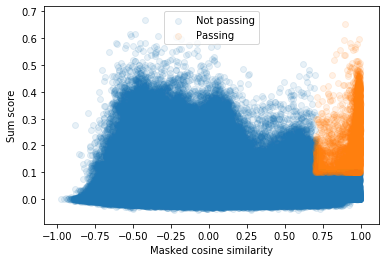

In [12]:
handles = []
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers==False].ravel(),
            sum_scores[threshold_passers==False].ravel(), alpha=0.1))
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers].ravel(),
            sum_scores[threshold_passers].ravel(), alpha=0.1))
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.legend(handles=handles, labels=["Not passing", "Passing"])
plt.show()

cosine similarity: 0.9621180018428115 sum scores: 0.1058703452559712


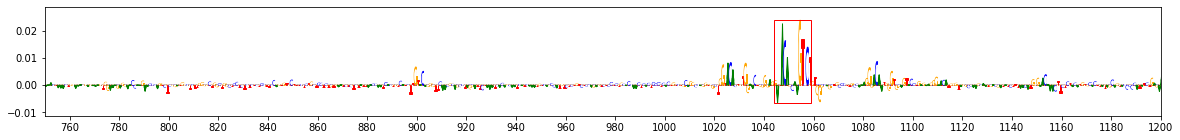

cosine similarity: 0.9615221659219739 sum scores: 0.23797790551834624


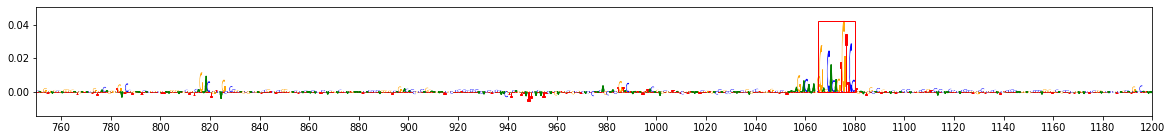

cosine similarity: 0.9773737050988346 sum scores: 0.31220983521634477


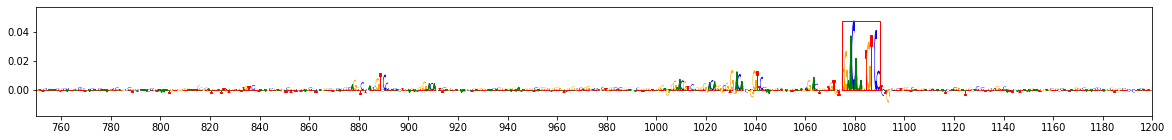

cosine similarity: 0.9413595769517867 sum scores: 0.36013184701296264


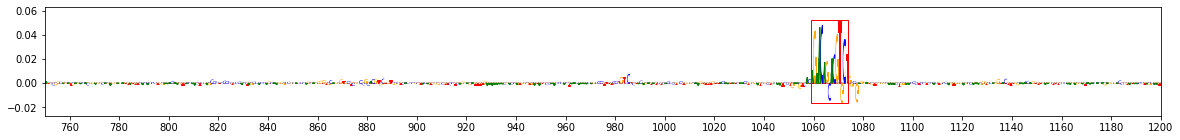

cosine similarity: 0.946486441611507 sum scores: 0.14486552768066757


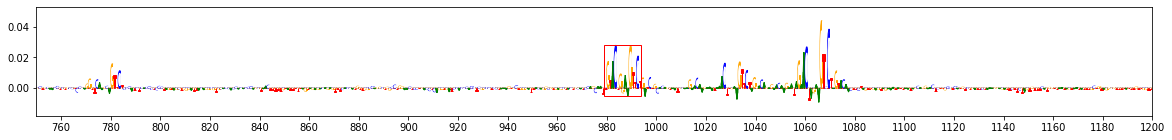

In [13]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
num_to_viz = 5
for (seq_idx, hit_pos) in hit_locations[:num_to_viz]:
    print("cosine similarity:", masked_cosine_sim[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)     
    viz_sequence.plot_weights_given_ax(ax=ax,
        array=imp_scores[seq_idx],
        height_padding_factor=0.2,
        length_padding=1.0,
        highlight={'red': [(hit_pos, hit_pos+len(trimmed))]},
        subticks_frequency=20)
    plt.xlim((750,1200))
    plt.show()

In [14]:
centered_imps = []
for (seq_idx, hit_pos) in hit_locations:
    centered_imps.append(imp_scores[seq_idx][hit_pos-100:hit_pos+100])
centered_imps = np.array(centered_imps)

counts imp


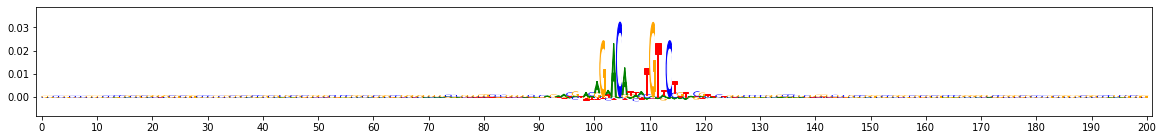

In [15]:
print("counts imp")
viz_sequence.plot_weights(np.mean(centered_imps, axis=0), subticks_frequency=10)

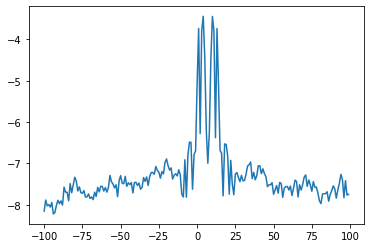

In [16]:
magnitude_imps = np.sum(centered_imps, axis=-1)
plt.plot(np.arange(-100,100,1), np.log(np.mean(magnitude_imps, axis=0)))

(-10, 70)

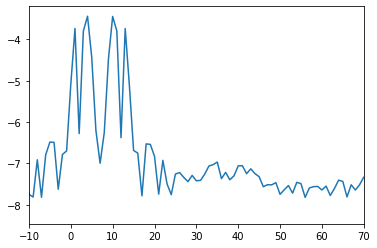

In [17]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(magnitude_imps, axis=0)))
plt.xlim((-10,70))

In [18]:
all_coords = np.load("/users/amr1/pho4/data/imp-scores/lncap_gr/coords.npy")

In [19]:
chrmToHits = {}
for (seq_idx, hit_pos) in hit_locations:
    chrm, _, interval = all_coords[seq_idx].split(':')
    start, _ = interval.split('-')
    if chrm not in chrmToHits:
        chrmToHits[chrm] = []
    chrmToHits[chrm].append(int(start)+hit_pos)

In [20]:
motif = trimmed["sequence"].fwd

In [21]:
len(motif)

15

In [22]:
distances = []
for chrm in chrmToHits:
    for idx in range(0, len(chrmToHits[chrm])):
        pos1 = chrmToHits[chrm][idx]
        for idy in range(idx+1, len(chrmToHits[chrm])):
            pos2 = chrmToHits[chrm][idy]
            dist = abs(pos1-pos2)
            if dist >= len(motif) and dist <= 100:
                distances.append(dist)

In [23]:
len(distances)

1729

Text(0.5, 1.0, 'Pair distances in genome')

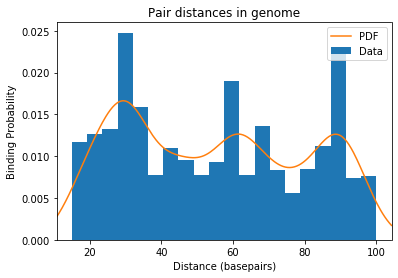

In [26]:
import scipy.stats as st

plt.hist(distances, density=True, bins=20, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 301)
kde = st.gaussian_kde(distances)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper right")
plt.ylabel('Binding Probability')
plt.xlabel('Distance (basepairs)')
plt.title("Pair distances in genome")

Text(0.5, 1.0, 'Pair distances in genome')

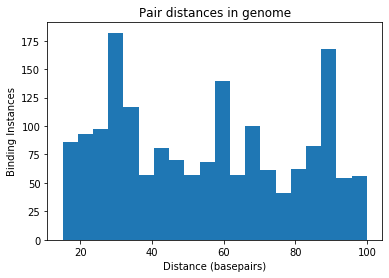

In [27]:
plt.hist(distances, density=False, bins=20, label="Data")
plt.ylabel('Binding Instances')
plt.xlabel('Distance (basepairs)')
plt.title("Pair distances in genome")